# Konstanz weekly 5k project
There is a weekly 5k running event in Konstanz in which I frequently participate and volunteer. There are some basic statistics about the historic results of this event that can be found online, but I decided it would be nice to do my own deep-dive into the history to discover the history of this event and uncover some trends and patterns in the underlying data.

I scraped the results from the event website using the two web-scraping notebooks included into this project. The data was scraped on the 08th and 9th of September and was fully anonymised for the protection of the personal data of the participants.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the data
The data is stored in two different csv-files:
* 5k_KN_history
* 5k_KN_full_results

Let's load the data and take a look at them both.

In [2]:
history = pd.read_csv('5k_KN_history.csv')
full_results = pd.read_csv('5k_KN_full_results.csv')

In [3]:
full_results.dtypes

event_nr            int64
position            int64
runner             object
agegroup           object
gender             object
club               object
time               object
age_grade         float64
no_runs             int64
no_volunteered    float64
dtype: object

As we can see, the history data contains key information about each time the event has taken place. This includes the date of the event, the times for both the first male and first female finisher, a unique identifier for each athlete, the number of finishers, the number of volunteers and the event number.

In [4]:
history.head()

,date,first_female,first_female_time,first_male,first_male_time,number_of_finishers,number_of_volunteers,event_number
0,2024-09-07,5699cd65bed4209bc59759b448de51190286cea23a6298...,21:52,59f265e789e06bdaa84e238b21c9eee1b77deaf5c9477c...,21:59,33,10,163
1,2024-08-31,c1bdb0c6d2ce725940fa4bf0685be1089684168d77e0c2...,24:32,a82f27a0311bd2368d57e44d8fb77773de976db2323001...,18:33,50,8,162
2,2024-08-24,5484cd1f589ff5150ca81fbf79ef7ede793d5b9940c9c5...,20:53,9fbf9a93fae3e98904d0f621d5fe3dfb097dd97070bff0...,17:50,46,10,161
3,2024-08-17,346b664808f9894132106819b084698de9dd97c88973b6...,21:12,ddc6c07003754b3c293eaed5804c15644f9fbb0f1b958a...,18:32,54,11,160
4,2024-08-10,c1bdb0c6d2ce725940fa4bf0685be1089684168d77e0c2...,24:49,393ab0078ae69a10bd651457336f864f3ffe8dd41b4bc4...,16:57,56,11,159


The full result data contains the full results for each time the event has taken place. The information inlcudes the event number, the finishing position of an athlete, a unique identifier for every runner (this one does not match the unique identifier from the other dataframe!), the agegroup and gender of each athlete, any club affiliation, the finishing time, a result metric that adjusts the result for age and gender (this is calculated through a rather complicated algorithm by the event organisers), as well as how often the runner has run and volunteered in an event organised by this global running community.

The last two columns show the information from the day the data was scraped not from the day the event took place. Furthermore, these two columns may have values higher than the event number because there are numerous other events all around the world organised by the same organisation.

In [5]:
full_results.head()

,event_nr,position,runner,agegroup,gender,club,time,age_grade,no_runs,no_volunteered
0,1,1,2934814864a608297772c1d79b25b4d05fee276be4efb3...,SM25-29,Männlich,NaN,18:31,69.67,136,0.0
1,1,2,a769395c83ad70f54a3e3a4af723eee6c713c62d5c385c...,SM20-24,Männlich,NaN,19:24,66.49,1,0.0
2,1,3,91830a6e6a59491f056e006bdd129e3df2ddc05e17d0de...,VM35-39,Männlich,Freiwillige Feuerwehr Frankfurt am Main-Praunheim,22:34,59.60,169,73.0
3,1,4,4f738dcd6691d171565edd4426c01abccf8a8db1904139...,VM50-54,Männlich,NaN,23:20,63.21,45,80.0
4,1,5,fb6c056bdbb1c70a9381bf1a9ad8e59d64188001e67448...,VM45-49,Männlich,NaN,24:24,58.54,11,1.0


### Cleaning
The data still needs some cleaning:
* merge the data frames (I want the columns date, number of finishers, number of volunteers all included in the full_results df)
* change datatypes of some columns (all columns with times and dates should be datetime or timedelta objects)
* treat NaN-Values

#### Merge data frames

In [6]:
full_results = full_results.merge(history, how='left', left_on='event_nr', right_on='event_number')

# drop some unnecessary columns
full_results = full_results[['event_nr', 'position', 'runner', 'agegroup', 'gender', 'club', 'time',
                            'age_grade', 'no_runs', 'no_volunteered', 'date', 
                            #'first_female', 'first_male',
                            'first_female_time', 'first_male_time',
                            'number_of_finishers', 'number_of_volunteers'
                            #'event_number'
                           ]]

#### Change dtypes
We now have one dataframe that contains all information. But we still want to change the data types for some the columns related to times and dates.

In [7]:
full_results.dtypes

event_nr                  int64
position                  int64
runner                   object
agegroup                 object
gender                   object
club                     object
time                     object
age_grade               float64
no_runs                   int64
no_volunteered          float64
date                     object
first_female_time        object
first_male_time          object
number_of_finishers       int64
number_of_volunteers      int64
dtype: object

In [8]:
# change data types of dates and times
full_results['date'] = pd.to_datetime(full_results['date'], format='%Y-%m-%d')
full_results['time'] = pd.to_timedelta(full_results['time'].apply(lambda x: np.nan if str(x) == 'nan' else '00:' + str(x) if len(str(x)) == 5 else "0" + str(x)))
full_results['first_female_time'] = pd.to_timedelta(full_results['first_female_time'].apply(lambda x: np.nan if str(x) == 'nan' else '00:' + str(x) if len(str(x)) == 5 else "0" + str(x)))
full_results['first_male_time'] = pd.to_timedelta(full_results['first_male_time'].apply(lambda x: np.nan if str(x) == 'nan' else '00:' + str(x) if len(str(x)) == 5 else "0" + str(x)))

#### Treat NaN-values
Now that this is done, let's take a look at NaN values in the data.

We can see there are a number of columns that have NaN values. Probably for different reasons, so let's take a look at each one of them:
* club: the club column has the most NaN values. This is most likely because not all athletes have a club affiliation. We will simply change the NaN values to "no club" to solve this.

agegroup, gender, time, agegrade and no_volunteered have very similar amount of NaNs. The reason for this is, that runners who are not registered with the organisation are still shown in the result list as UNKNOWN runner but there is no time in the results list on the website for them. Since they are not registered, there is also no information about their age and gender and how often they volunteered. There seem to be 4 instances of a registered runner who has not given any information about their age and gender during the registration.

Here is how I will treat the columns:

* no_volunteered: if a runner is not registered with the organisation they are not allowed to volunteer. Therefore all NaN values in this column will be set to 0
* agegroup: Will simply be set to "no agegroup"
* age_grade: this value is normally calculated using info about age, gender and time. We're unable to interpolate age and gender so we can't calculate this ourselves. it will be set to 'no agegrade'
* gender: Will be set to "other" as there is no way to interpolate here
* time: we can use interpolation to replace the NaN/NaT values in this column. Sadly pandas only allows front fill or back fill interpolation for timedelta types. We will use backfill so there are no fills from other event days (the last finisher is always registered because they are part of the organisation, this is not necessarily the case for the first finisher)
* since all runners who are not registered are shown as UNKNOWN in the results, they all have the same anonymous runner ID. this will be changed to unknown. logically this has to be done before backfilling the time.

In [9]:
full_results.isnull().sum()

event_nr                   0
position                   0
runner                     0
agegroup                 132
gender                   132
club                    3335
time                     128
age_grade                132
no_runs                    0
no_volunteered           128
date                       0
first_female_time          0
first_male_time            0
number_of_finishers        0
number_of_volunteers       0
dtype: int64

In [10]:
full_results.loc[full_results['time'].isna(), 'runner'] = 'UNKNOWN'

full_results['time'] = full_results['time'].bfill()
full_results['club'] = full_results['club'].apply(lambda x: 'no club' if pd.isna(x) else x)
full_results['agegroup'] = full_results['agegroup'].apply(lambda x: 'no agegroup' if pd.isna(x) else x)
full_results['gender'] = full_results['gender'].apply(lambda x: 'other' if pd.isna(x) else x)
full_results['no_volunteered'] = full_results['no_volunteered'].apply(lambda x: 0 if pd.isna(x) else x)

In [11]:
full_results.isnull().sum()

event_nr                  0
position                  0
runner                    0
agegroup                  0
gender                    0
club                      0
time                      0
age_grade               132
no_runs                   0
no_volunteered            0
date                      0
first_female_time         0
first_male_time           0
number_of_finishers       0
number_of_volunteers      0
dtype: int64

### Adding some more data
We now have a pretty clean dataframe. For the EDA that I have in mind, I would like some more information:

* season/month: I suspect that there will be differnces in performance and in attendance between the seasons/months. Hence I will create two columns "month" and "season".
* average speed: In order to compare performance, I will create a column with the average speed.

In [12]:
full_results['month'] = full_results['date'].apply(lambda x: x.month)
full_results['season'] = full_results['month'].apply(lambda x: 'spring' if 2 < x < 6 else 'summer' if 5 < x < 9 else 'autumn' if 8 < x < 12 else 'winter')

full_results['avg_speed_kph'] = full_results['time'].apply(lambda x: 5 / (x.seconds/3600))

full_results.head()

,event_nr,position,runner,agegroup,gender,club,time,age_grade,no_runs,no_volunteered,date,first_female_time,first_male_time,number_of_finishers,number_of_volunteers,month,season,avg_speed_kph
0,1,1,2934814864a608297772c1d79b25b4d05fee276be4efb3...,SM25-29,Männlich,no club,0 days 00:18:31,69.67,136,0.0,2021-08-14,0 days 00:25:15,0 days 00:18:31,26,7,8,summer,16.201620
1,1,2,a769395c83ad70f54a3e3a4af723eee6c713c62d5c385c...,SM20-24,Männlich,no club,0 days 00:19:24,66.49,1,0.0,2021-08-14,0 days 00:25:15,0 days 00:18:31,26,7,8,summer,15.463918
2,1,3,91830a6e6a59491f056e006bdd129e3df2ddc05e17d0de...,VM35-39,Männlich,Freiwillige Feuerwehr Frankfurt am Main-Praunheim,0 days 00:22:34,59.60,169,73.0,2021-08-14,0 days 00:25:15,0 days 00:18:31,26,7,8,summer,13.293944
3,1,4,4f738dcd6691d171565edd4426c01abccf8a8db1904139...,VM50-54,Männlich,no club,0 days 00:23:20,63.21,45,80.0,2021-08-14,0 days 00:25:15,0 days 00:18:31,26,7,8,summer,12.857143
4,1,5,fb6c056bdbb1c70a9381bf1a9ad8e59d64188001e67448...,VM45-49,Männlich,no club,0 days 00:24:24,58.54,11,1.0,2021-08-14,0 days 00:25:15,0 days 00:18:31,26,7,8,summer,12.295082


### EDA
Now let's begin with the fun part and do some simple exploratory data analysis.

Let's first get some very basic descriptive statistics.

In [13]:
mean_time = full_results["time"].mean()
finisher_stats = full_results['number_of_finishers'].agg(['min', 'max', 'mean'])
cr_men = full_results.loc[full_results['gender'] == 'Männlich']['time'].min()
cr_women = full_results.loc[full_results['gender'] == 'Weiblich']['time'].min()

print(f'Total unique runners: {full_results["runner"].nunique()}')
print(f'Average finishing time: {str(mean_time.components.hours).zfill(2)}:{str(mean_time.components.minutes).zfill(2)}:{str(mean_time.components.seconds).zfill(2)}')
print(f'Course record men: {str(cr_men.components.hours).zfill(2)}:{str(cr_men.components.minutes).zfill(2)}:{str(cr_men.components.seconds).zfill(2)}')
print(f'Course record women: {str(cr_women.components.hours).zfill(2)}:{str(cr_women.components.minutes).zfill(2)}:{str(cr_women.components.seconds).zfill(2)}')
print(f'Age grade record: {full_results["age_grade"].max()}%')
print(f'Least finishers: {int(finisher_stats[0])}')
print(f'Most finishers: {int(finisher_stats[1])}')
print(f'Average number of finishers: {round(finisher_stats[2], 2)}')
print(f'Most runs (overall): {full_results.groupby("runner")["no_runs"].max().max()}')
print(f'Most runs (in Konstanz): {full_results.loc[full_results["runner"] != "UNKNOWN"]["runner"].value_counts().max()}')
print(f'Most volunteer credits (overall): {full_results.groupby("runner")["no_volunteered"].max().max()}')

Total unique runners: 1220
Average finishing time: 00:30:37
Course record men: 00:16:51
Course record women: 00:18:36
Age grade record: 84.81%
Least finishers: 8
Most finishers: 125
Average number of finishers: 31.78
Most runs (overall): 725
Most runs (in Konstanz): 104
Most volunteer credits (overall): 564.0


This is already quite a bit of interesting information that we retrieved from the dataset. I'm also interested, in how some of the columns relate to each other. E.g. 
* how high is the ration of runners who have never volunteered? 
* Are there differences in average speed and attendance depending on the season? 
* Are there general trends regarding average speed and attendance? 
* What is the distribution of agegroups and gender? 
* Is there a correlation between the number of times a runner has run and the number of times they have volunteered? 
* Are runners that have a club affiliation faster than runners who don't?

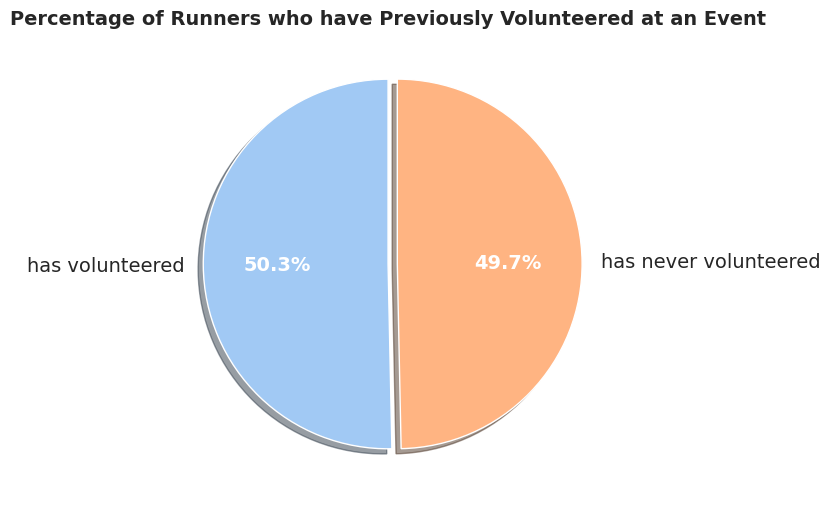

In [14]:
# create binary column for volunteered
full_results['volunteered_bi'] = full_results['no_volunteered'].apply(lambda x: 'no' if x == 0 else 'yes')

# only keep unique runner ids (so we only have one value per runner)
volunteered_data = full_results.drop_duplicates(subset=['runner']).reset_index(drop=True)

# calculate percentage and turn it into a dataframe for plotting
pie_data = {'labels': list(round(volunteered_data['volunteered_bi'].value_counts(normalize=True)*100, 2).index),
            'values': list(round(volunteered_data['volunteered_bi'].value_counts(normalize=True)*100, 2))}

pie_data = pd.DataFrame(pie_data)

# plot the data
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
_, _, texts = plt.pie(x=pie_data['values'], 
                      labels=['has volunteered', 'has never volunteered'], 
                      autopct='%1.1f%%', 
                      startangle=90, 
                      shadow=True, 
                      explode=[0, 0.05], 
                      colors=sns.color_palette('pastel'),
                      textprops={'fontsize':14})
plt.title('Percentage of Runners who have Previously Volunteered at an Event', fontdict={'fontsize':14, 'fontweight':'bold'})

for text in texts:
    text.set_color('white')
    text.set_fontweight('bold')
plt.show()

It seems that almost exactly half of the runners who have participated in the event in Konstanz have previously volunteered at an event of the same global running organisation.

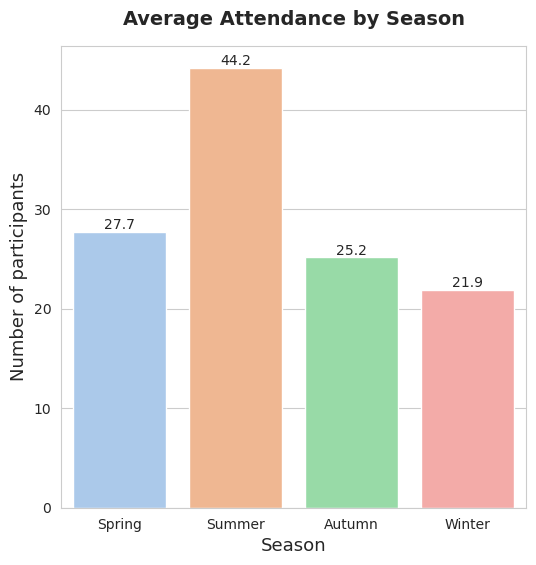

In [15]:
# Create a plot that shows the average number of finishers by each season
plt.figure(figsize=(6,6))
ax = sns.barplot(x=full_results['season'], 
                 y=full_results['number_of_finishers'], 
                 palette='pastel', 
                 order=['spring', 'summer', 'autumn', 'winter'], 
                 ci=None)
ax.bar_label(ax.containers[0], fmt='%.1f')
ax.set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
plt.title('Average Attendance by Season', fontdict={'fontsize':14, 'fontweight':'bold'}, pad=15)
plt.xlabel('Season', fontsize=13)
plt.ylabel('Number of participants', fontsize=13)

plt.show()

Quite clearly, summer has the highest attendance. This is in parts because people enjoy running more when it's warm and in parts because there is a lot of tourists coming to join this running event from out of town.

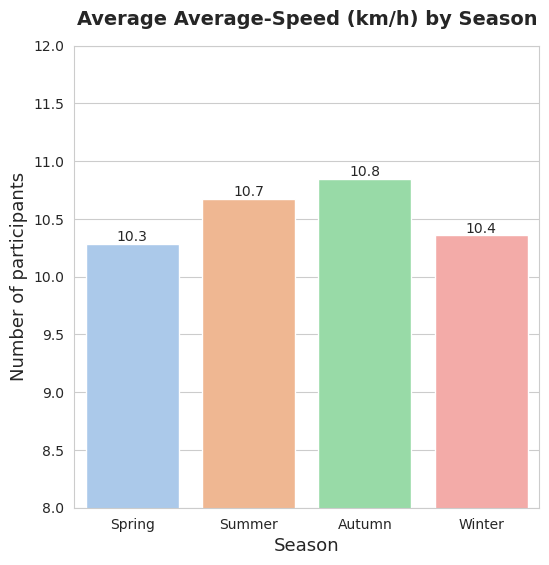

In [17]:
# Create a plot that shows the average speed by each season
plt.figure(figsize=(6,6))
ax = sns.barplot(x=full_results['season'], 
                 y=full_results['avg_speed_kph'], 
                 palette='pastel', 
                 order=['spring', 'summer', 'autumn', 'winter'], 
                 ci=None)
ax.bar_label(ax.containers[0], fmt='%.1f')
ax.set_xticklabels(['Spring', 'Summer', 'Autumn', 'Winter'])
ax.set_ylim(8, 12)
plt.title('Average Average-Speed (km/h) by Season', fontdict={'fontsize':14, 'fontweight':'bold'}, pad=15)
plt.xlabel('Season', fontsize=13)
plt.ylabel('Number of participants', fontsize=13)

plt.show()

The speed differences between seasons don't seem too big on paper, but 0.5 km/h (the difference between spring and autumn) over 5 kilometer (the event distance) comes out to almost 1:30 min difference in finishing time, which is quite a large margin over the 5 kilometer distance.

It must be noted here, that this depicts the overall mean of the average speed. This is mathematically different from the average speed of the mean finishing time.

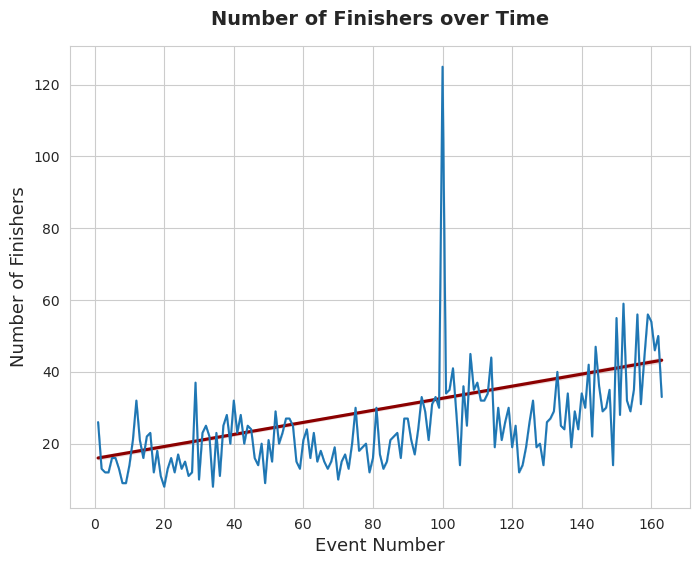

In [64]:
plt.figure(figsize=(8,6))
sns.regplot(data=full_results, x='event_nr', y='number_of_finishers', scatter_kws={'s':0}, color='darkred')
sns.lineplot(x=full_results['event_nr'], y=full_results['number_of_finishers'])
plt.title('Number of Finishers over Time', fontdict={'fontsize':14, 'fontweight':'bold'}, pad=15)
plt.xlabel('Event Number', fontsize=13)
plt.ylabel('Number of Finishers', fontsize=13)

plt.show()

If we look at the number of finishers for each time the event was held, the first thing that (quite literally) spikes out is that one event had many more finishers than all others. This was the 100th event, which was celebrated together with 125 runners.

We can also observe a general increase in participants over time. If we look closely, we can also observe higher attendance numbers around event numbers 40-60, 90-110 and 145-160+. Given that this is a weekly event, these are likely seasonal changes with peaks in the summer.

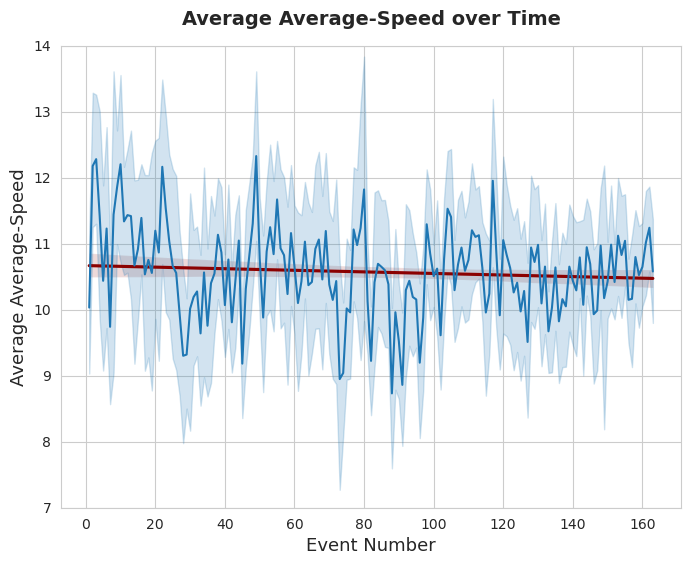

In [85]:
plt.figure(figsize=(8,6))
sns.regplot(data=full_results, x='event_nr', y='avg_speed_kph', scatter_kws={'s':0}, color='darkred')
sns.lineplot(x=full_results['event_nr'], y=full_results['avg_speed_kph'])
plt.title('Average Average-Speed over Time', fontdict={'fontsize':14, 'fontweight':'bold'}, pad=15)
plt.xlabel('Event Number', fontsize=13)
plt.ylabel('Average Average-Speed', fontsize=13)
plt.ylim((7, 14))

plt.show()

Looking of the average of the average athlete speed over time, there seems to be no real trend in the data. However, it seems that the variance between events has decreased after around the 130th event. This could potentially **correlate with increasing attendance numbers**. With higher attendance numbers, the mean of the average speed will converge closer to the true average running speed in the population.

In [98]:
full_results['club_bi'] = full_results['club'].apply(lambda x: 'no club-runner' if x == 'no club' else 'club-runner')

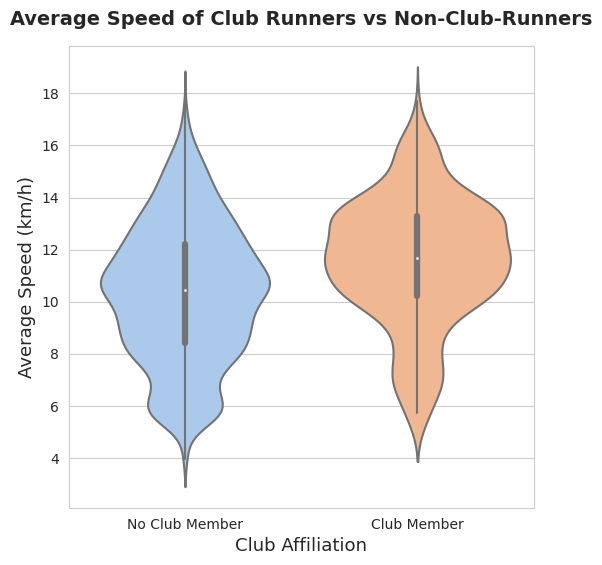

In [123]:
plt.figure(figsize=(6,6))
ax = sns.violinplot(x=full_results['club_bi'], y=full_results['avg_speed_kph'], palette='pastel')
ax.set_xticklabels(['No Club Member', 'Club Member'])
plt.title('Average Speed of Club Runners vs Non-Club-Runners', fontdict={'fontsize':14, 'fontweight':'bold'}, pad=15)
plt.xlabel('Club Affiliation', fontsize=13)
plt.ylabel('Average Speed (km/h)', fontsize=13)
plt.show()

Relatively unsurprisingly, Club Runners are faster than non-club runners.